In [127]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

%config InlineBackend.figure_format = 'retina'
import os
import warnings
warnings.filterwarnings('ignore')

In [128]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [129]:
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

if os.path.exists('sunf.jpg'):
    print('sunf.jpg exists')

sunf.jpg exists


In [130]:
img = torchvision.io.read_image("sunf.jpg")
print(img.shape)

torch.Size([3, 853, 1280])


In [131]:
from sklearn import preprocessing
scaler_img = preprocessing.MinMaxScaler().fit(img.cpu().reshape(-1, 1))
scaler_img

MinMaxScaler()

In [132]:

img_scaled = scaler_img.transform(img.cpu().reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled.shape


torch.Size([3, 853, 1280])

In [133]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 200, 600, 400, 400)

crop.shape

torch.Size([3, 400, 400])

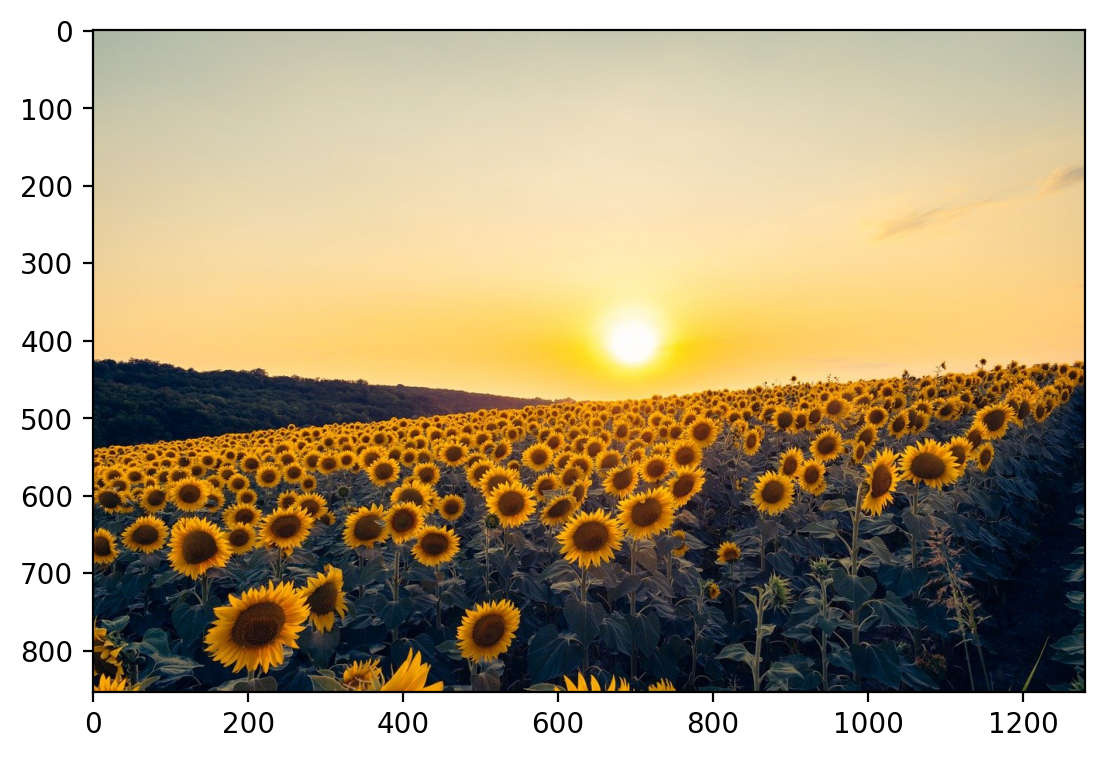

In [134]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())



In [135]:
crop.shape

torch.Size([3, 400, 400])

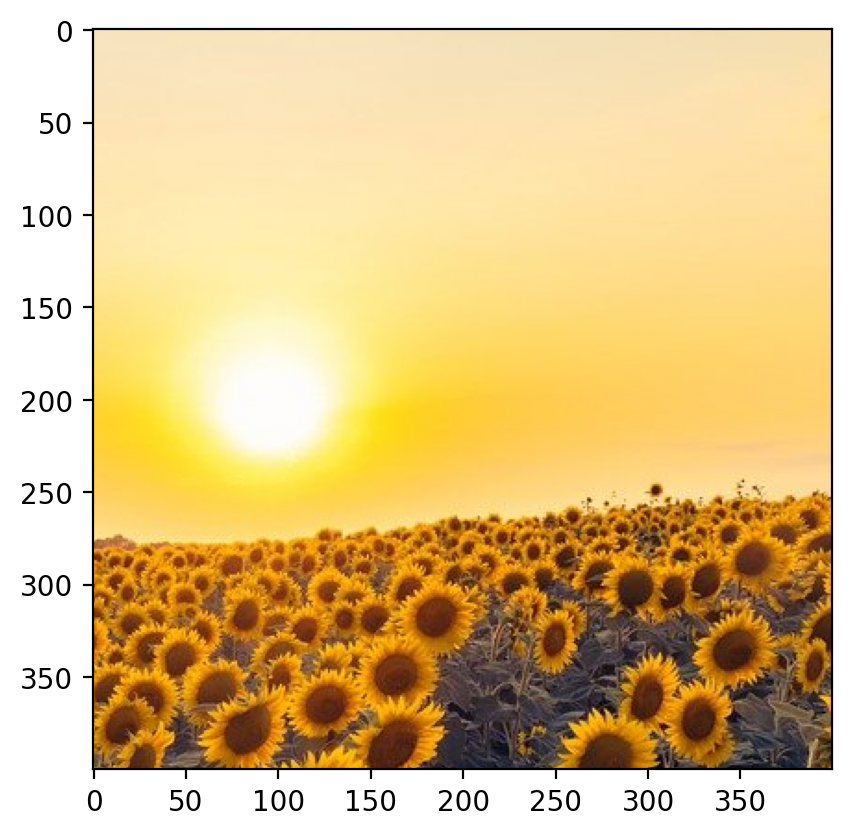

In [136]:
plt.imshow(rearrange(crop, 'c h w -> h w c').numpy())

In [137]:
crop = crop.to(device)

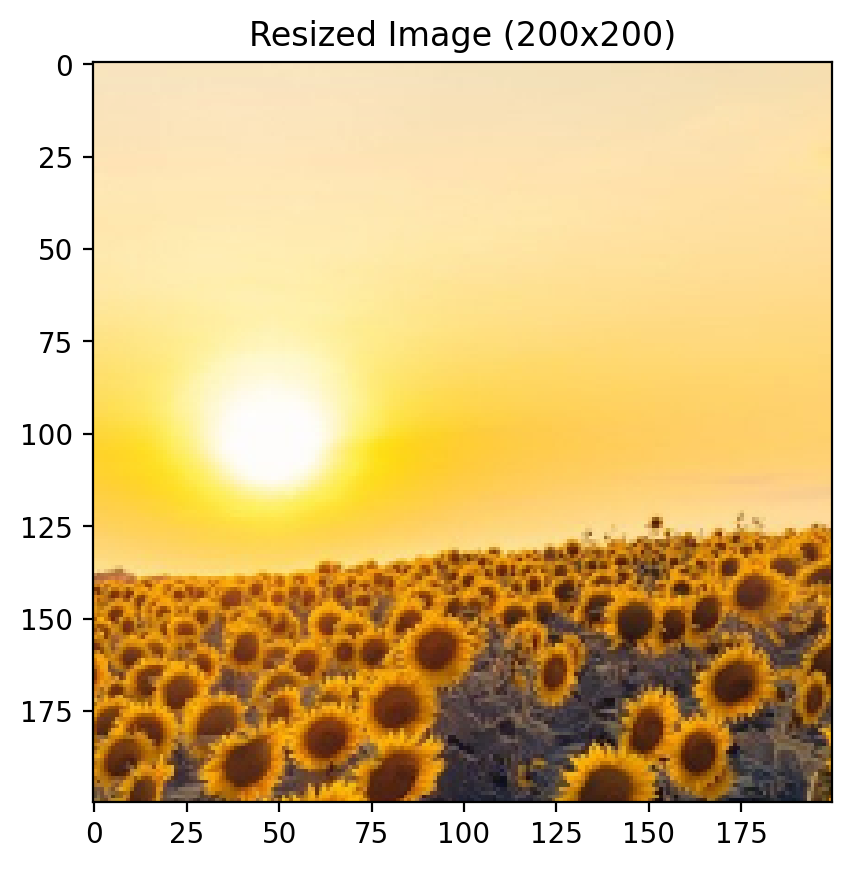

torch.Size([3, 200, 200])

In [138]:
import cv2
crop400 = crop.permute(1, 2, 0).cpu().numpy()


img200_np = cv2.resize(crop400, (200,200), interpolation=cv2.INTER_LINEAR)  # Resizing with interpolation

img200 = torch.tensor(img200_np).permute(2, 0, 1)
plt.imshow(rearrange(img200, 'c h w -> h w c').numpy())
plt.title("Resized Image (200x200)")
plt.axis('on')
plt.show()

# # img200_tensor.shape
img200.shape

In [139]:
num_channels, height, width = img200.shape
print(num_channels, height, width)

3 200 200


In [140]:
num_channels, height, width = 2, 3, 4


# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)


# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()
X.shape

torch.Size([12, 2])

In [141]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)


    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [142]:
sun_X, sun_Y = create_coordinate_map(img200)

sun_X.shape, sun_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [143]:
# scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Mukesh_X.cpu())
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(sun_X.cpu())

# Scale the X coordinates
# Mukesh_X_scaled = scaler_X.transform(Mukesh_X.cpu())
sun_X_scaled = scaler_X.transform(sun_X.cpu())

# Move the scaled X coordinates to the GPU
sun_X_scaled = torch.tensor(sun_X_scaled).to(device)
# deer_X_scaled = torch.tensor(deer_X_scaled)


# Set to dtype float32
sunf_X_scaled = sun_X_scaled.float()

In [144]:
sunf_X_scaled.shape

torch.Size([40000, 2])

In [145]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [146]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [147]:
def plot_reconstructed_and_original_image(original_img, net, X, title="",scale=1):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    height*=scale
    width*=scale
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Super-resoluted Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("on")




    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return outputs


In [148]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state=42)
    X = X.cpu().numpy()
    # X = X.numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)
    # return torch.tensor(X, dtype=torch.float32)

In [149]:
# reduce the number of features
X_rff = create_rff_features(sun_X_scaled,5000, 0.02)


In [150]:
sun_X_scaled.shape
print(X_rff.shape)

torch.Size([40000, 5000])


In [151]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, sun_Y, 1000)

Epoch 0 loss: 0.526036
Epoch 100 loss: 0.094469
Epoch 200 loss: 0.023528
Epoch 300 loss: 0.009976
Epoch 400 loss: 0.005507
Epoch 500 loss: 0.003636
Epoch 600 loss: 0.002833
Epoch 700 loss: 0.002493
Epoch 800 loss: 0.002348
Epoch 900 loss: 0.002281


0.0022458634339272976

tensor([[[1.0411, 0.9995, 0.7822],
         [0.9835, 0.9150, 0.7250],
         [0.9555, 0.8771, 0.7005],
         ...,
         [0.9167, 0.8498, 0.6914],
         [0.8948, 0.8285, 0.6755],
         [0.8344, 0.7617, 0.5721]],

        [[1.0128, 0.9496, 0.7733],
         [0.9697, 0.8909, 0.7591],
         [0.9555, 0.8700, 0.7498],
         ...,
         [0.9882, 0.8980, 0.7541],
         [0.9947, 0.8994, 0.7392],
         [0.9638, 0.8649, 0.6502]],

        [[0.9855, 0.9059, 0.7444],
         [0.9582, 0.8719, 0.7622],
         [0.9516, 0.8617, 0.7562],
         ...,
         [1.0038, 0.9016, 0.7485],
         [1.0192, 0.9121, 0.7409],
         [1.0031, 0.8988, 0.6788]],

        ...,

        [[0.4861, 0.3713, 0.2449],
         [0.4235, 0.2966, 0.1869],
         [0.4281, 0.2979, 0.2062],
         ...,
         [0.2832, 0.1971, 0.0803],
         [0.2552, 0.1621, 0.0407],
         [0.3384, 0.2062, 0.0713]],

        [[0.5260, 0.4264, 0.2999],
         [0.4234, 0.3151, 0.2095],
         [0.

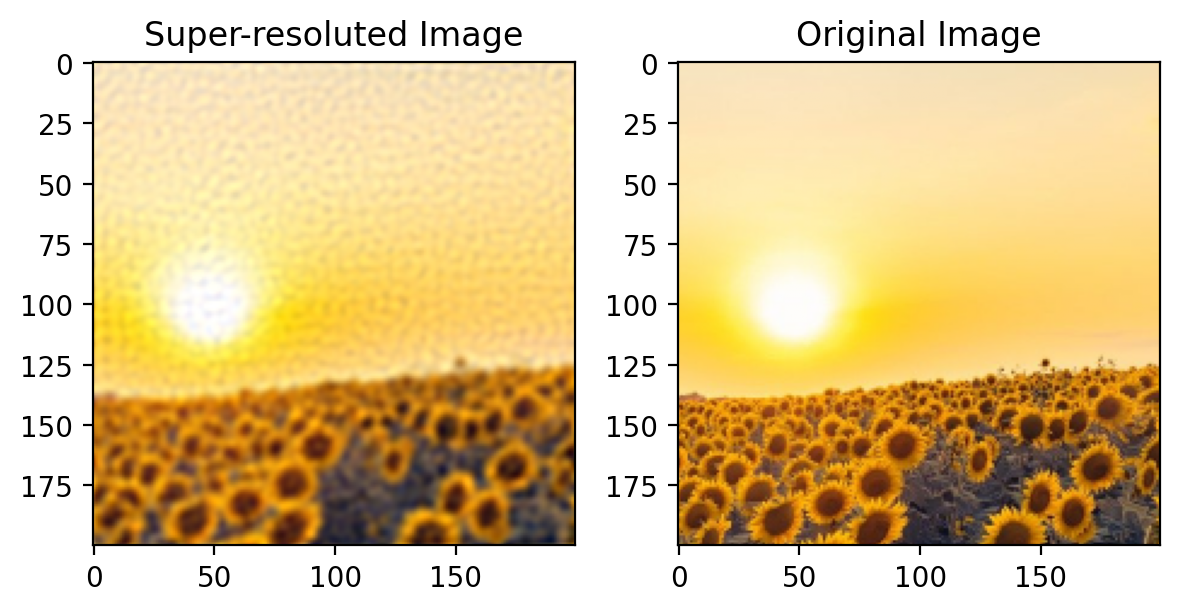

In [152]:
plot_reconstructed_and_original_image(img200, net, X_rff)

In [153]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [154]:
sun_X_n, sun_Y_n = create_coordinate_map(img200, scale = 2)
print(sun_X_n.shape, sun_Y_n.shape)

torch.Size([160000, 2]) torch.Size([40000, 3])


In [155]:
scaler_X_n = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(sun_X_n.cpu())
sun_X_scaled = scaler_X_n.transform(sun_X_n.cpu())
sun_X_scaled = torch.tensor(sun_X_scaled).to(device)
sun_X_scaled = sun_X_scaled.float()
print(sun_X_scaled.shape)

torch.Size([160000, 2])


In [156]:
X_rff = create_rff_features(sun_X_scaled, 5000, 0.02)
print(X_rff.shape)

torch.Size([160000, 5000])


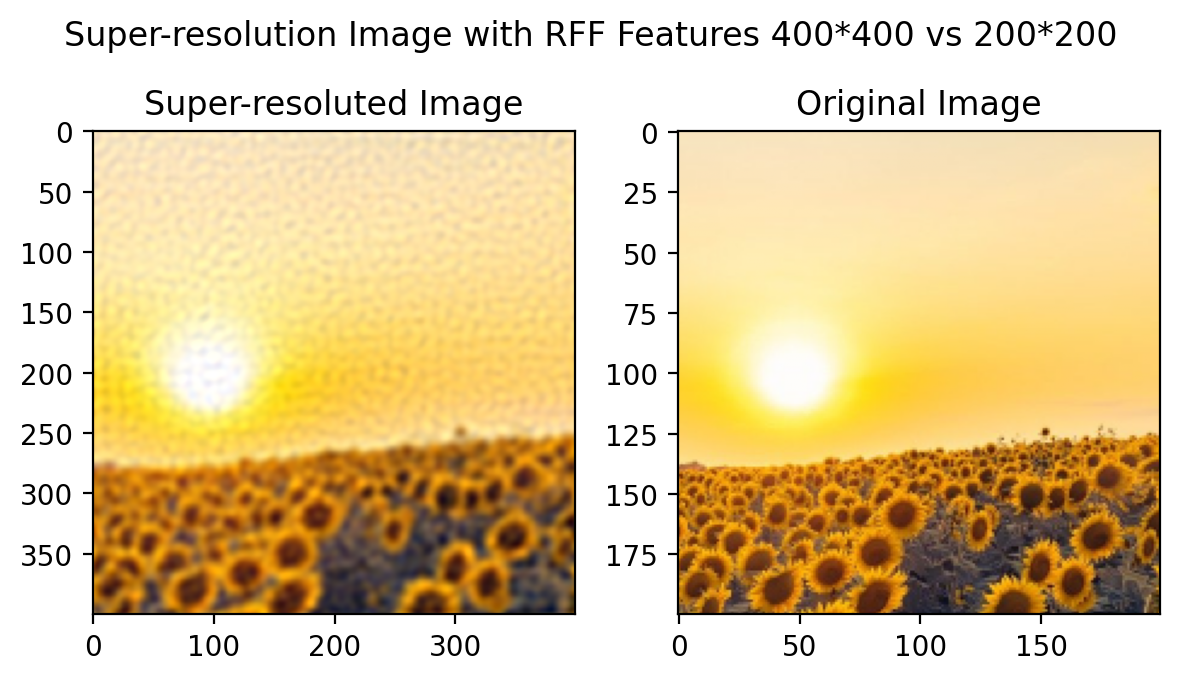

In [157]:
recon_400=plot_reconstructed_and_original_image(img200, net, X_rff, title = "Super-resolution Image with RFF Features 400*400 vs 200*200", scale = 2)

In [158]:
#RMSE AND PSNR
def cal_rmse(original_img, reconstructed_img):
    # Convert tensors to NumPy arrays and move to CPU if needed
    original_image = original_img.cpu().numpy()
    reconstructed_image = reconstructed_img.cpu().numpy()

    # Compute RMSE
    mse = np.mean((original_image - reconstructed_image) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def cal_psnr(original_img, reconstructed_img):
    rmse = cal_rmse(original_img, reconstructed_img)

    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / rmse)
    return psnr


**RMSE**

In [159]:
recon_400 = recon_400.permute(2, 0, 1)
cal_rmse(crop,recon_400)


0.060410034648997135

**PSNR**

In [160]:
cal_psnr(crop, recon_400)

24.377818303499087

In [161]:
def showImage(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape

    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Super-resoltuted Image")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("on")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()



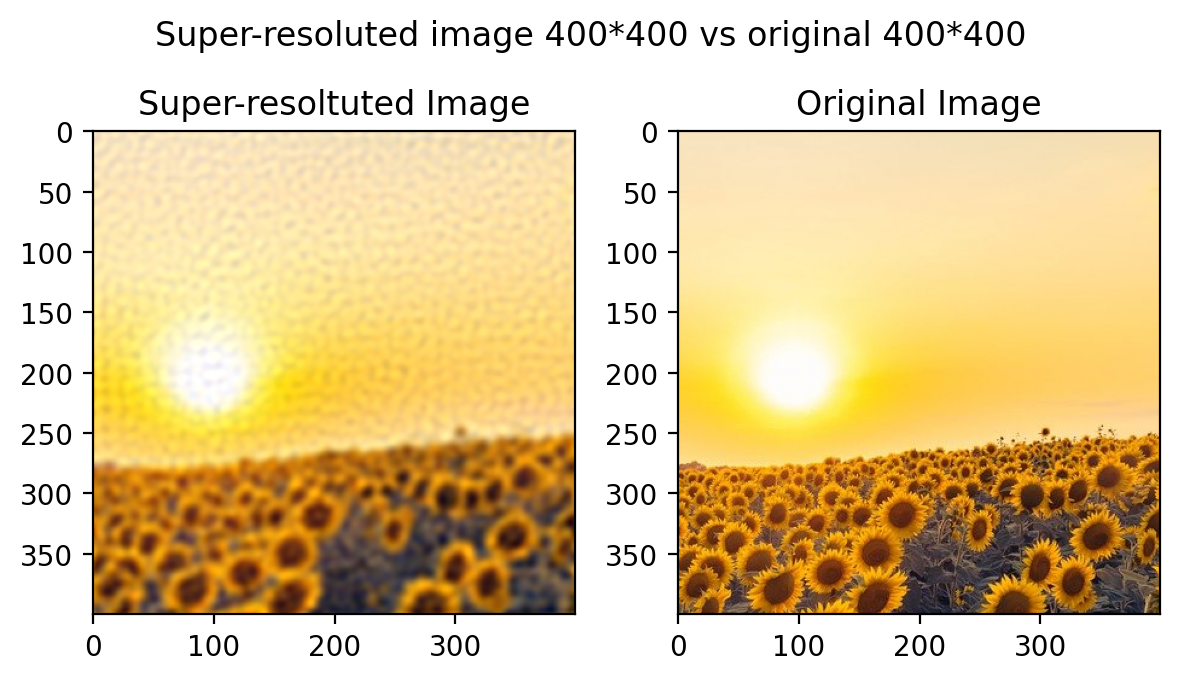

In [162]:
showImage(crop,net,X_rff,title ="Super-resoluted image 400*400 vs original 400*400")